
📊 Processing IOWait:
  🔍 CPU STRESS:
    ✅ Cleaned 44 outliers across all CPU cores
  🔍 BASELINE:
    ✅ Cleaned 137 outliers across all CPU cores

📊 Processing IRQ:
  🔍 CPU STRESS:
    ✅ Cleaned 176 outliers across all CPU cores
  🔍 BASELINE:
    ✅ Cleaned 264 outliers across all CPU cores

📊 Processing System:
  🔍 CPU STRESS:
    ✅ Cleaned 24 outliers across all CPU cores
  🔍 BASELINE:
    ✅ Cleaned 116 outliers across all CPU cores

📊 Processing User:
  🔍 CPU STRESS:
    ✅ Cleaned 11 outliers across all CPU cores
  🔍 BASELINE:
    ✅ Cleaned 238 outliers across all CPU cores

📊 Processing Utilization:
  🔍 CPU STRESS:
    ✅ Cleaned 36 outliers across all CPU cores
  🔍 BASELINE:
    ✅ Cleaned 264 outliers across all CPU cores

COMPREHENSIVE CPU STRESS ANALYSIS

🔄 Analyzing IOWait...


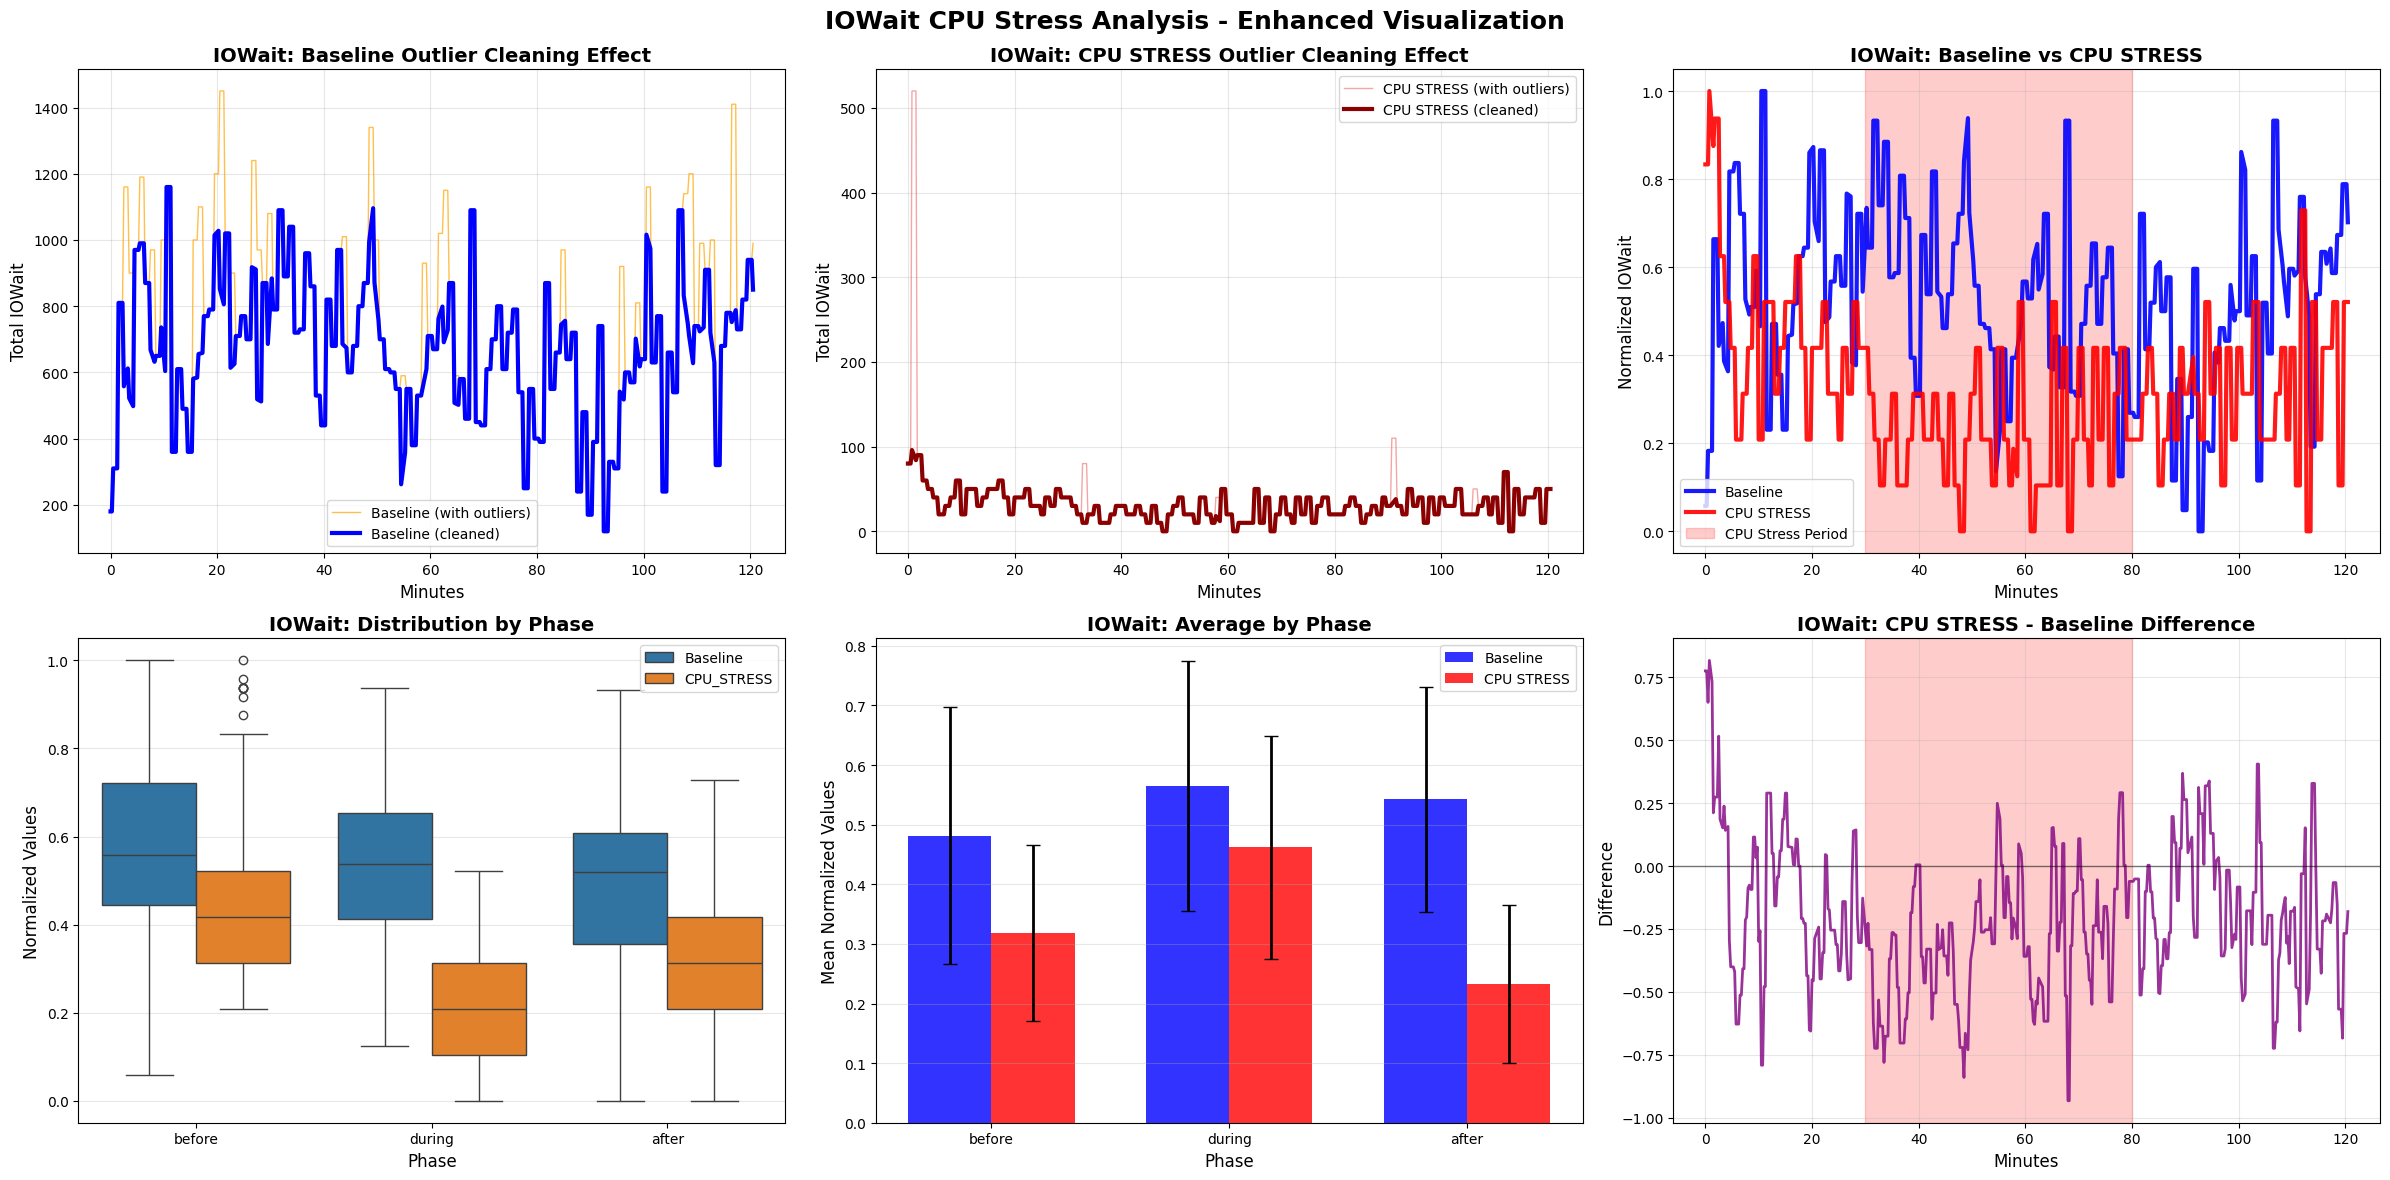


IOWAIT - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4818  0.2161  0.0000  0.9327
before  0.5646  0.2093  0.0577  1.0000
during  0.5425  0.1884  0.1250  0.9385

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3183  0.1482  0.0000  0.7292
before  0.4618  0.1877  0.2083  1.0000
during  0.2322  0.1327  0.0000  0.5208

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  4.00, p=  0.0001 (✅ SIGNIFICANT)
  DURING  : t= 19.09, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=  7.94, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -18.20% (↘️ DECREASE)
  DURING  :  -57.20% (↘️ DECREASE)
  AFTER   :  -33.93% (↘️ DECREASE)

🔄 Analyzing IRQ...


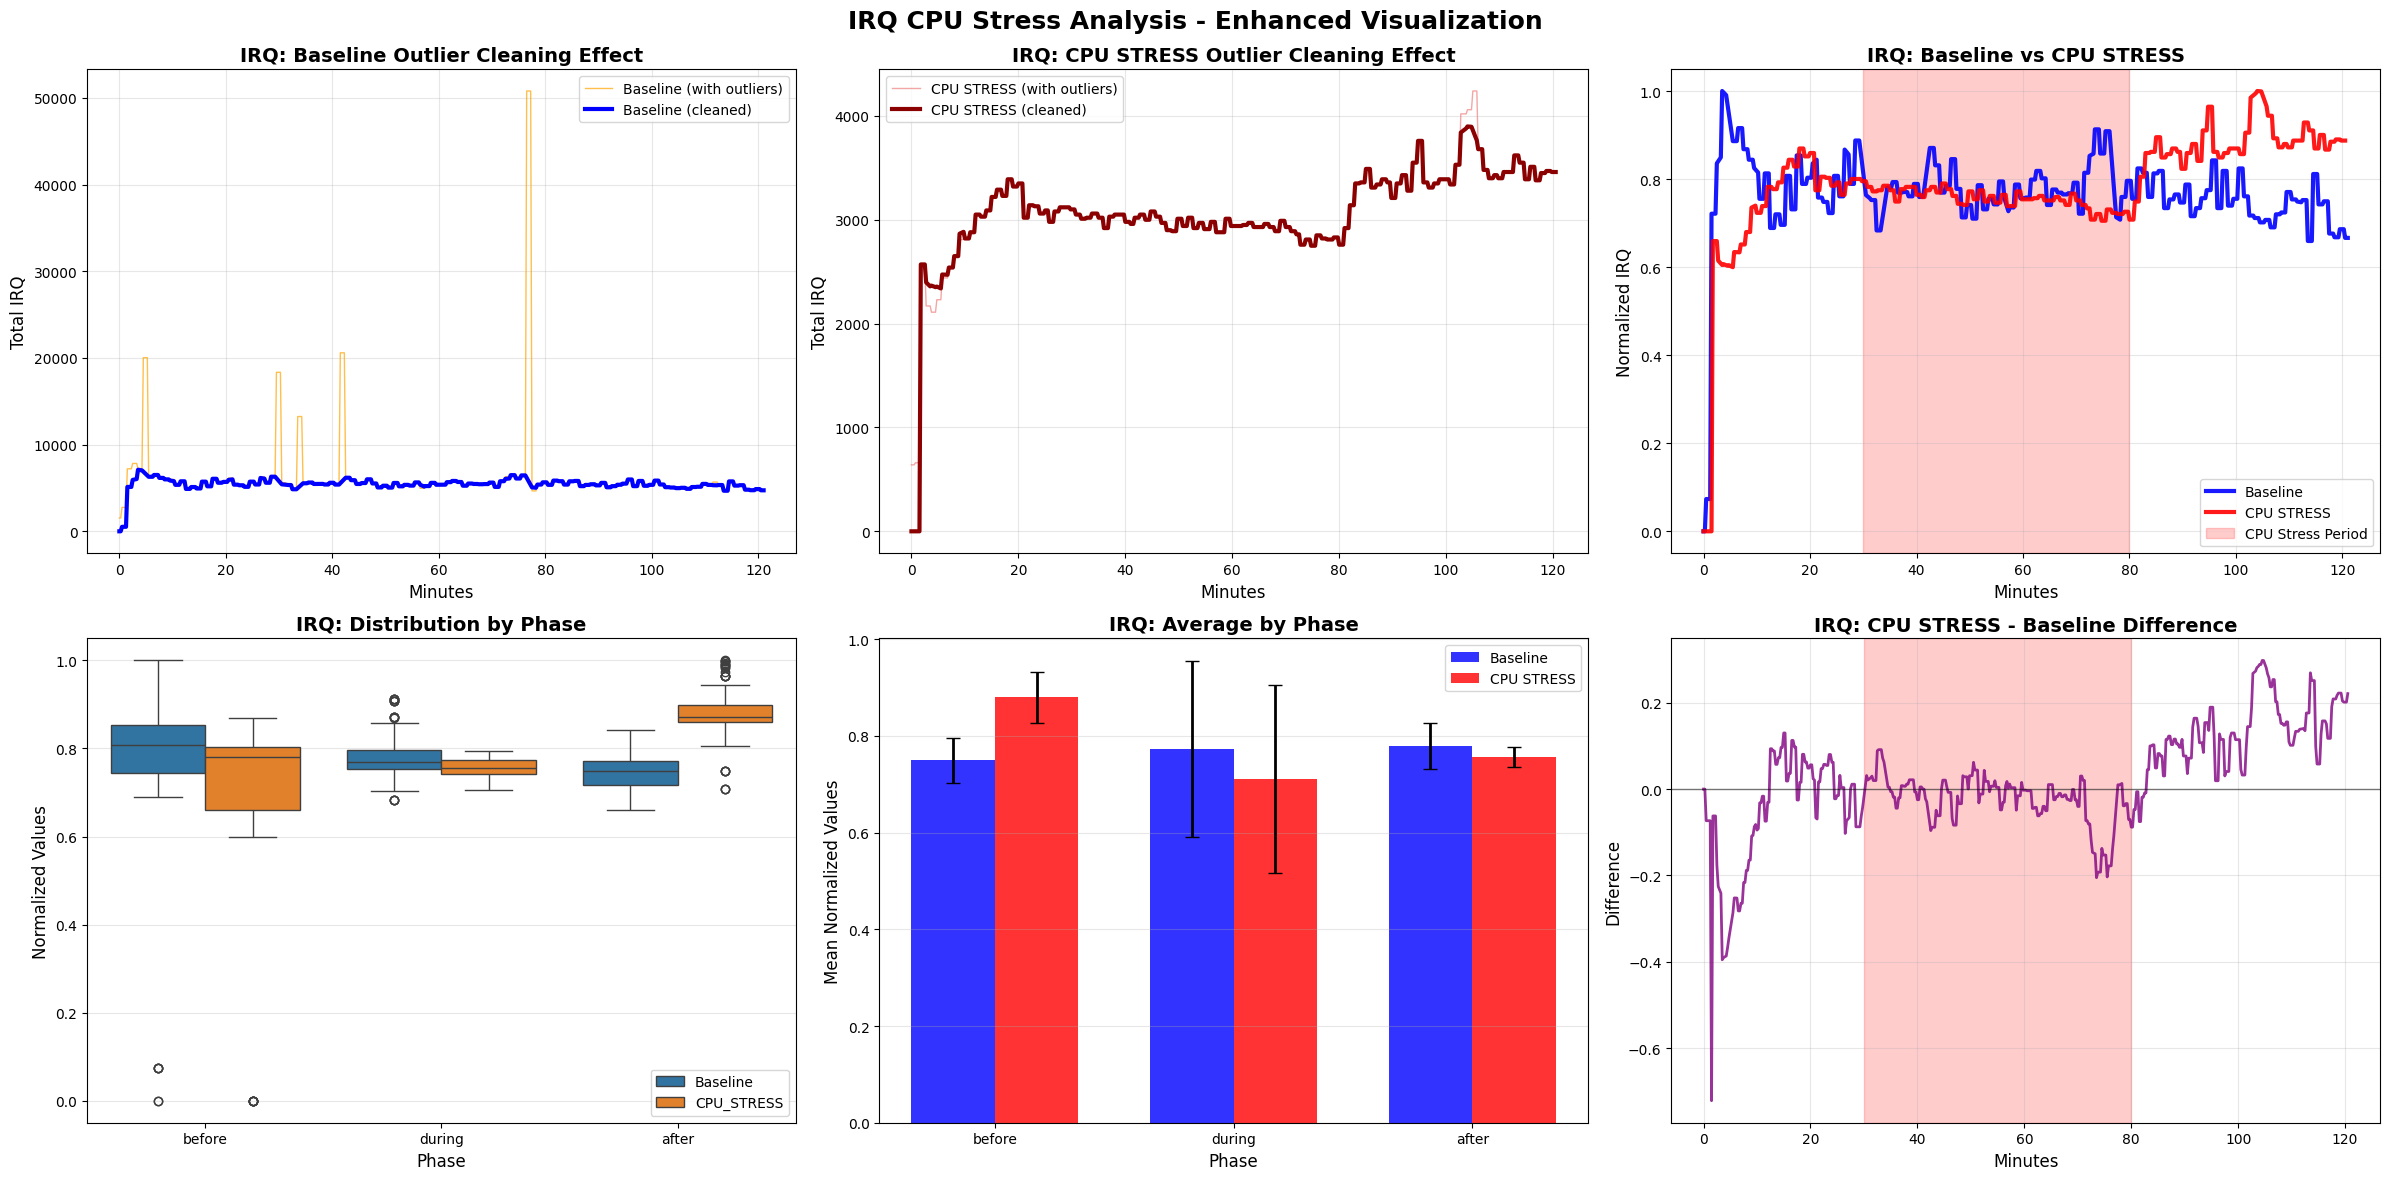


IRQ - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7492  0.0465  0.6594  0.8425
before  0.7721  0.1819  0.0000  1.0000
during  0.7796  0.0481  0.6833  0.9130

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.8800  0.0527  0.7079  1.0000
before  0.7115  0.1941  0.0000  0.8695
during  0.7560  0.0213  0.7053  0.7951

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  2.49, p=  0.0133 (✅ SIGNIFICANT)
  DURING  : t=  6.37, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=-23.77, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :   -7.85% (↘️ DECREASE)
  DURING  :   -3.03% (↘️ DECREASE)
  AFTER   :  +17.46% (↗️ INCREASE)

🔄 Analyzing System...


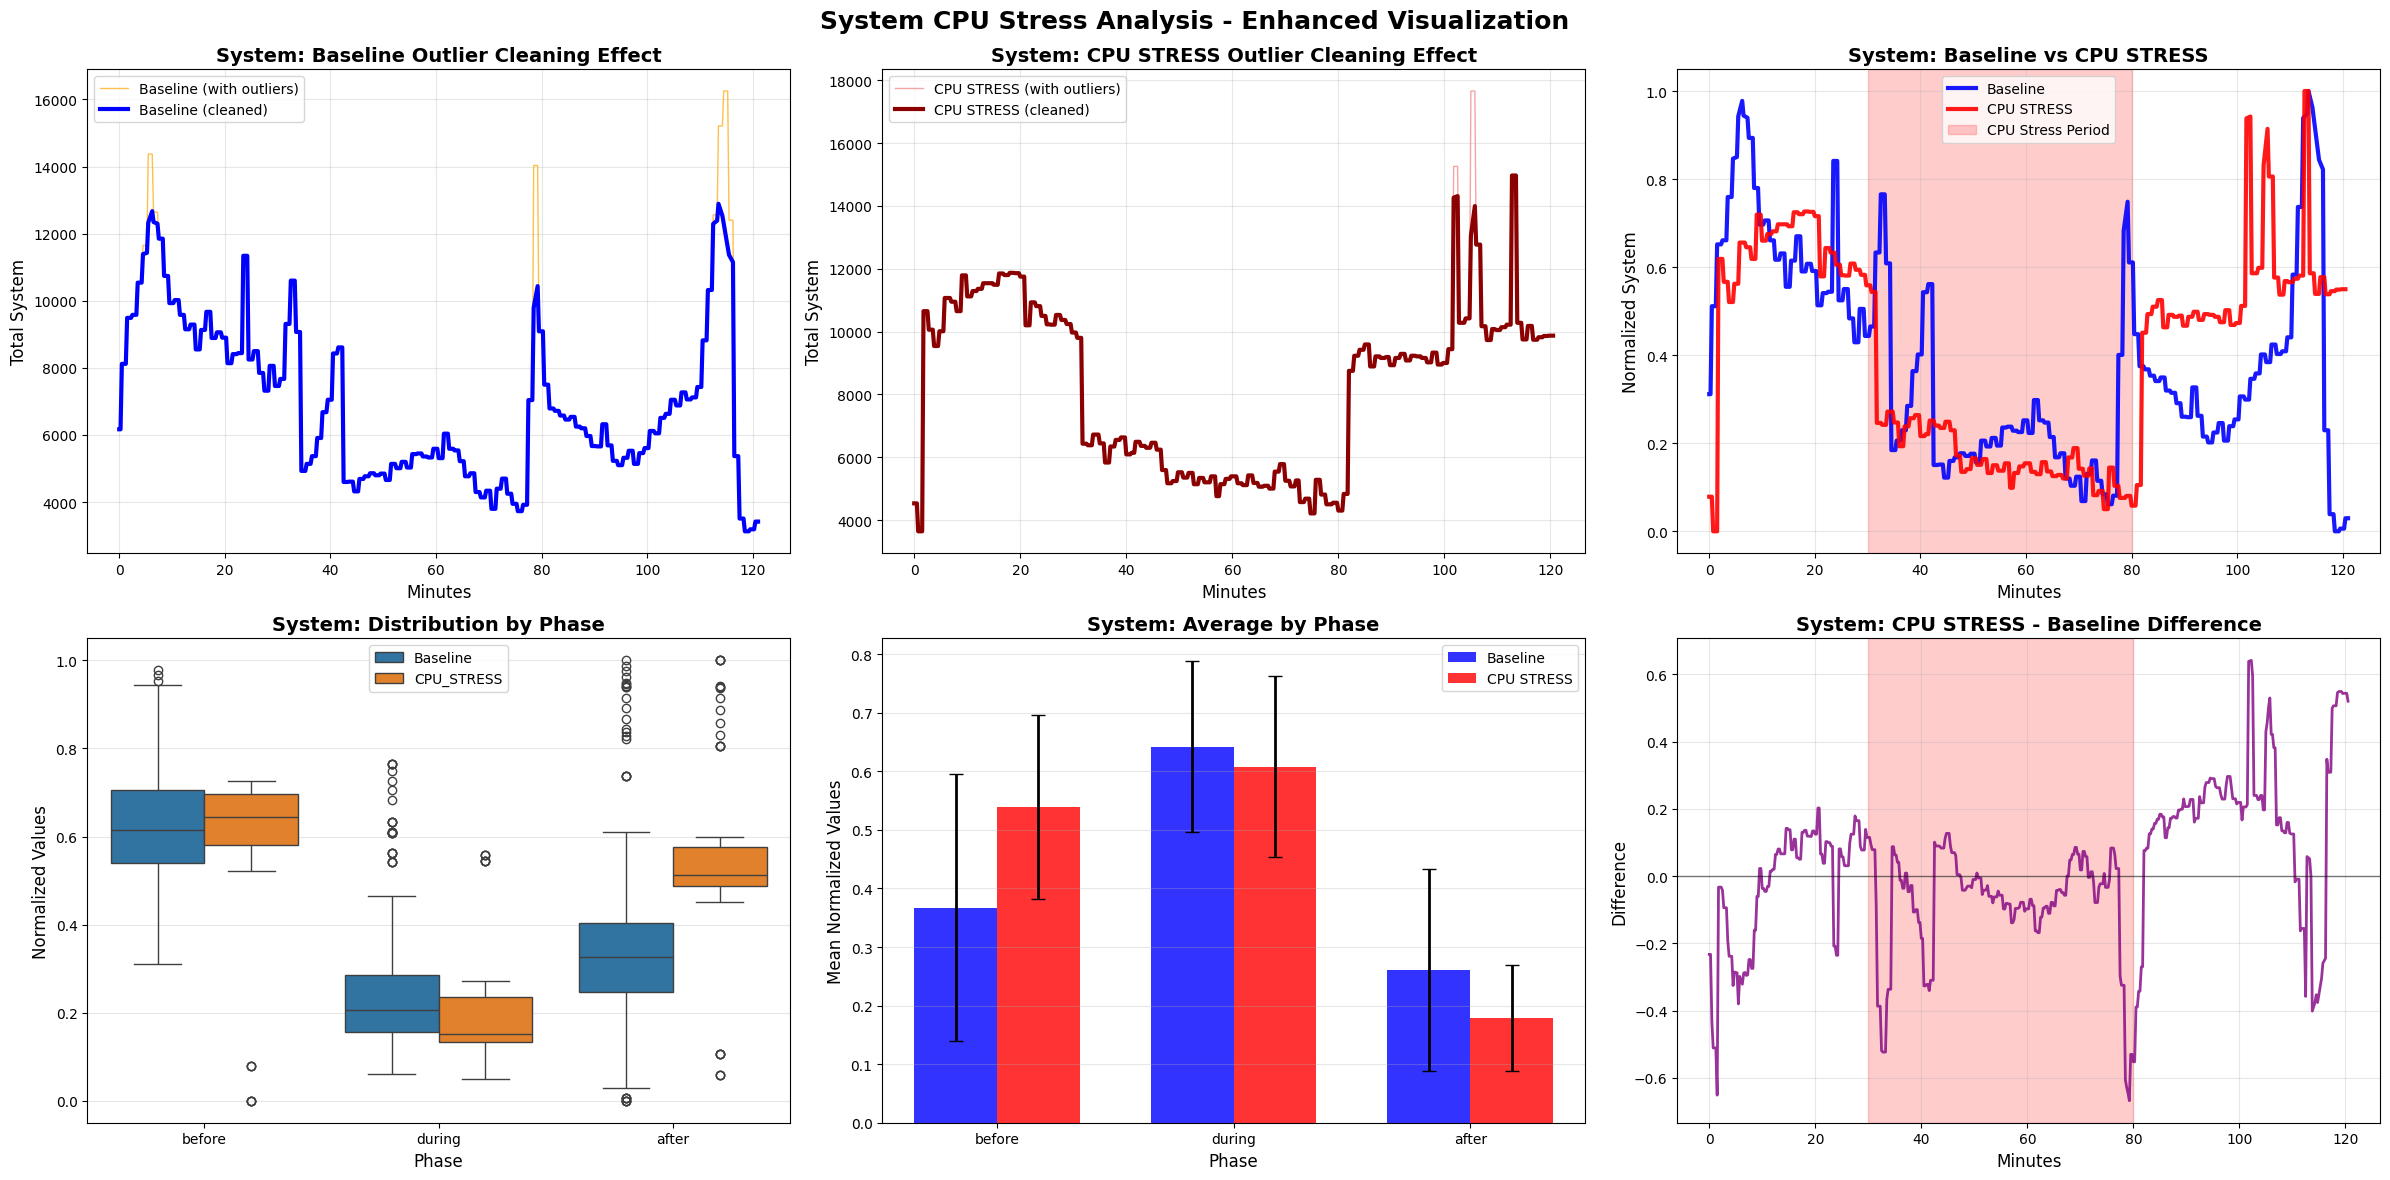


SYSTEM - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3673  0.2274  0.0000  1.0000
before  0.6419  0.1458  0.3115  0.9775
during  0.2605  0.1725  0.0615  0.7654

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5400  0.1571  0.0583  1.0000
before  0.6083  0.1550  0.0000  0.7264
during  0.1788  0.0907  0.0503  0.5587

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  1.73, p=  0.0848 (❌ NOT SIGNIFICANT)
  DURING  : t=  5.94, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= -7.97, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :   -5.24% (↘️ DECREASE)
  DURING  :  -31.34% (↘️ DECREASE)
  AFTER   :  +47.02% (↗️ INCREASE)

🔄 Analyzing User...


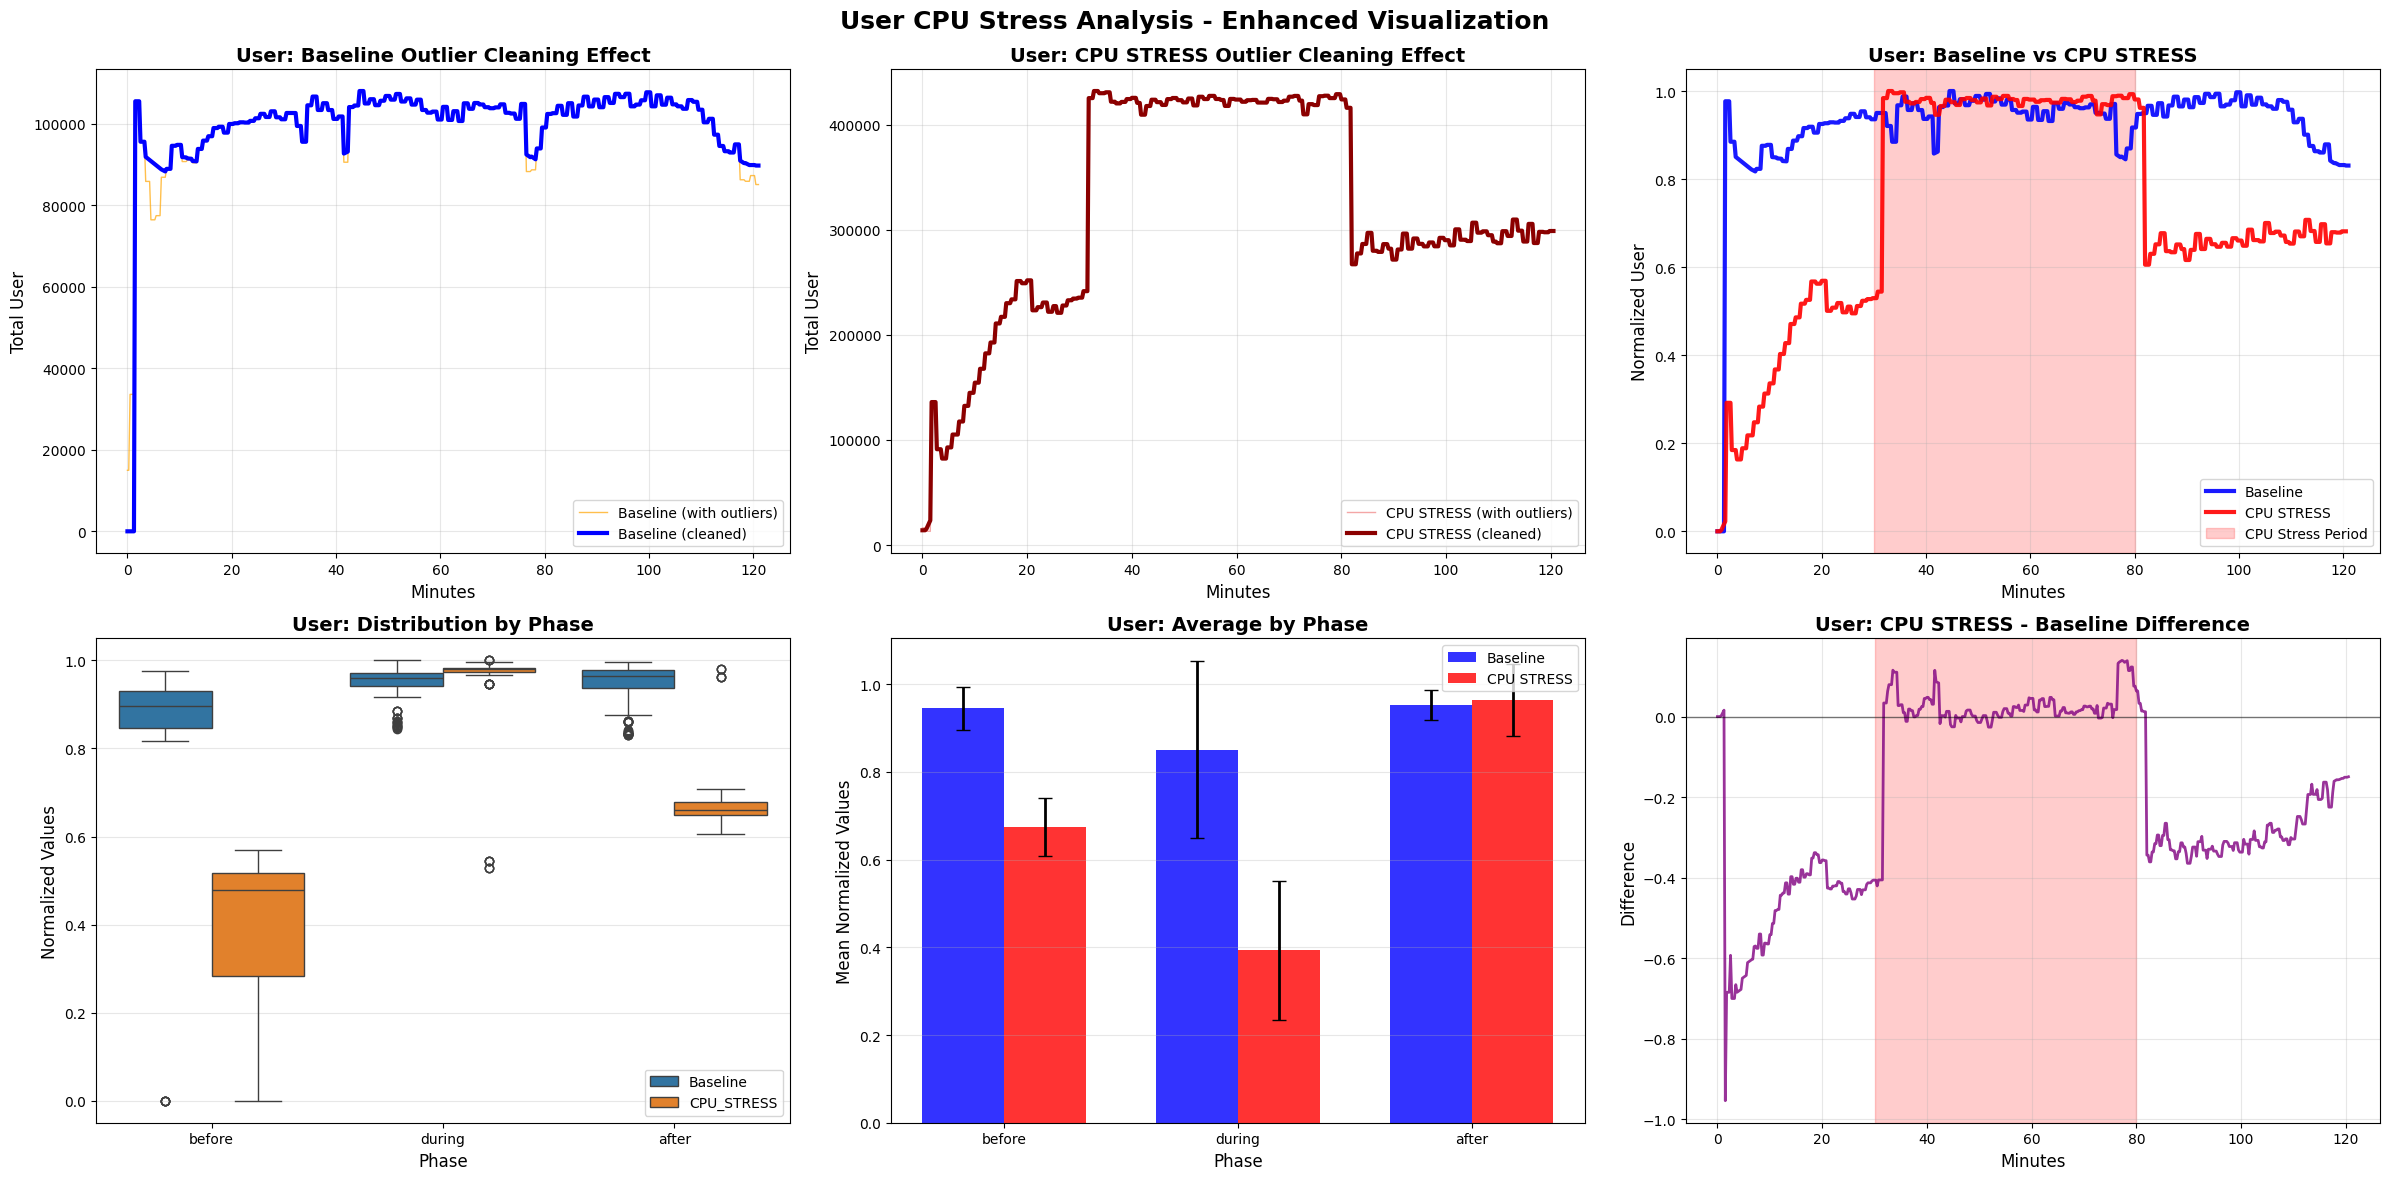


USER - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9451  0.0493  0.8307  0.9971
before  0.8510  0.2008  0.0000  0.9767
during  0.9519  0.0346  0.8450  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.6743  0.0666  0.6056  0.9808
before  0.3929  0.1594  0.0000  0.5690
during  0.9636  0.0817  0.5296  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 19.57, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -1.88, p=  0.0608 (❌ NOT SIGNIFICANT)
  AFTER   : t= 41.76, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -53.83% (↘️ DECREASE)
  DURING  :   +1.24% (↗️ INCREASE)
  AFTER   :  -28.65% (↘️ DECREASE)

🔄 Analyzing Utilization...


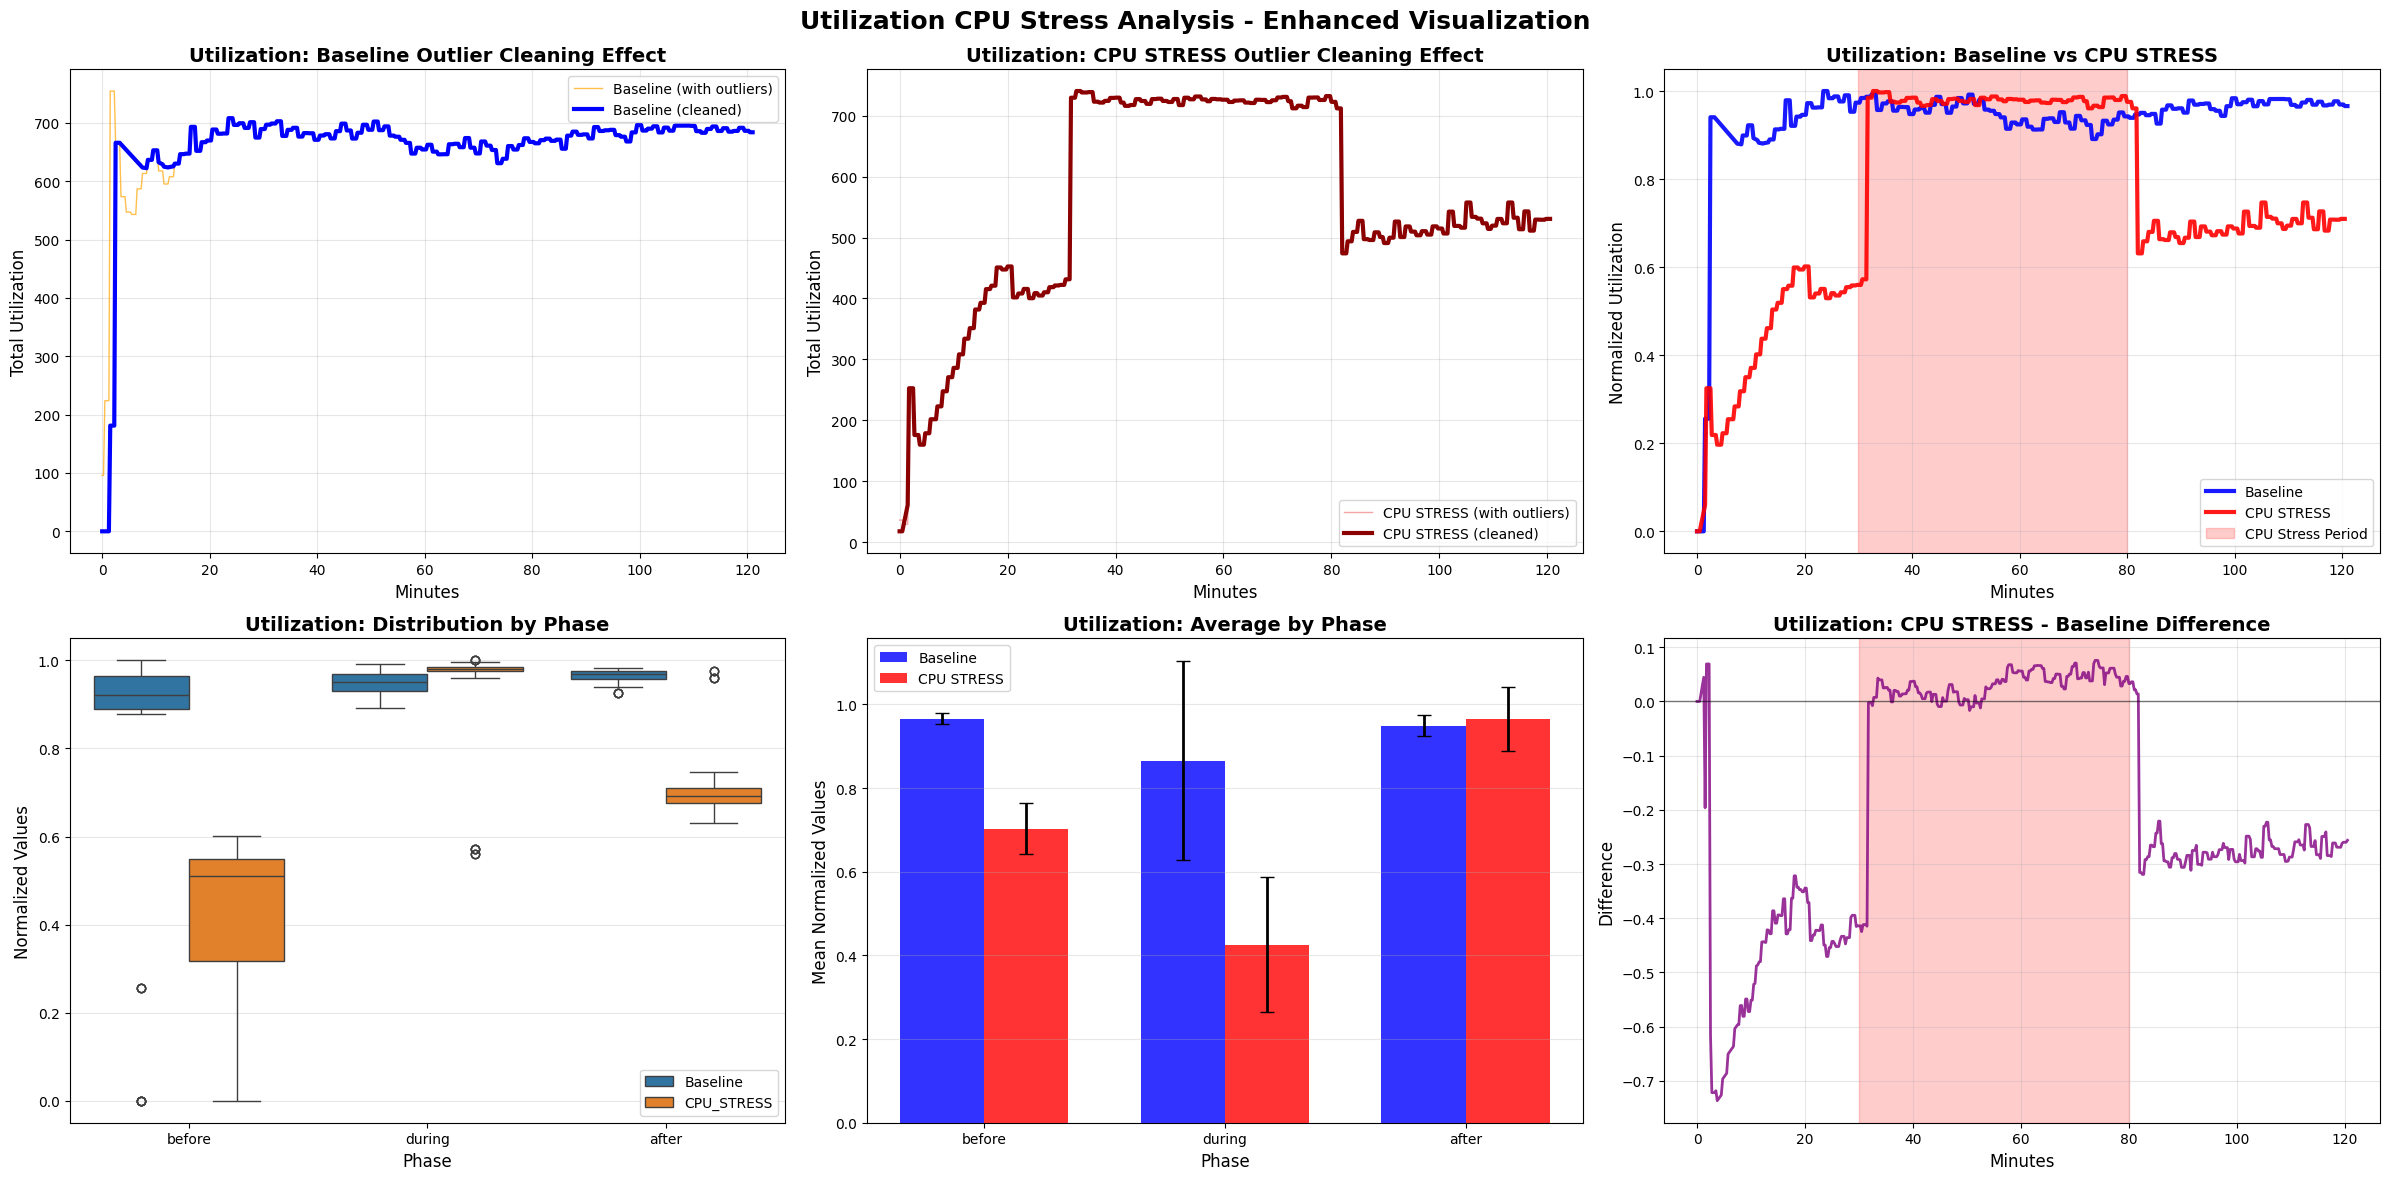


UTILIZATION - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std    min     max
phase                                
after   0.9655  0.0134  0.926  0.9836
before  0.8658  0.2368  0.000  1.0000
during  0.9489  0.0247  0.891  0.9925

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7031  0.0610  0.6313  0.9754
before  0.4252  0.1614  0.0000  0.6015
during  0.9651  0.0762  0.5596  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 16.84, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -2.86, p=  0.0045 (✅ SIGNIFICANT)
  AFTER   : t= 53.80, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -50.89% (↘️ DECREASE)
  DURING  :   +1.70% (↗️ INCREASE)
  AFTER   :  -27.18% (↘️ DECREASE)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats

# Load all datasets
df_iowait = pd.read_csv("cpu_iowait.csv")
df_cpu_irq = pd.read_csv("cpu_irq.csv")
df_system_msec = pd.read_csv("cpu_system_msec.csv")
df_user_msec = pd.read_csv("cpu_user_msec.csv")
df_cpu_util = pd.read_csv("cpu_util_per.csv")

df_baseline_iowait = pd.read_csv("../../baseline/cpu related/cpu_iowait.csv")
df_baseline_irq = pd.read_csv("../../baseline/cpu related/cpu_irq.csv")
df_baseline_system_msec = pd.read_csv("../../baseline/cpu related/cpu_system_msec.csv")
df_baseline_user_msec = pd.read_csv("../../baseline/cpu related/cpu_user_msec.csv")
df_baseline_util_per = pd.read_csv("../../baseline/cpu related/cpu_util_per.csv")

# Add source labels
df_iowait["source"] = "CPU STRESS"
df_cpu_irq["source"] = "CPU STRESS"
df_system_msec["source"] = "CPU STRESS"
df_user_msec["source"] = "CPU STRESS"
df_cpu_util["source"] = "CPU STRESS"

df_baseline_iowait["source"] = "BASELINE"
df_baseline_irq["source"] = "BASELINE"
df_baseline_system_msec["source"] = "BASELINE"
df_baseline_user_msec["source"] = "BASELINE"
df_baseline_util_per["source"] = "BASELINE"

# Convert to datetime
df_iowait["Time"] = pd.to_datetime(df_iowait["Time"])
df_cpu_irq["Time"] = pd.to_datetime(df_cpu_irq["Time"])
df_system_msec["Time"] = pd.to_datetime(df_system_msec["Time"])
df_user_msec["Time"] = pd.to_datetime(df_user_msec["Time"])
df_cpu_util["Time"] = pd.to_datetime(df_cpu_util["Time"])

df_baseline_iowait["Time"] = pd.to_datetime(df_baseline_iowait["Time"])
df_baseline_irq["Time"] = pd.to_datetime(df_baseline_irq["Time"])
df_baseline_system_msec["Time"] = pd.to_datetime(df_baseline_system_msec["Time"]) 
df_baseline_user_msec["Time"] = pd.to_datetime(df_baseline_user_msec["Time"])
df_baseline_util_per["Time"] = pd.to_datetime(df_baseline_util_per["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] += time_offset
df_cpu_irq["Time"] += time_offset
df_system_msec["Time"] += time_offset
df_user_msec["Time"] += time_offset
df_cpu_util["Time"] += time_offset

# Convert timeline to minutes 
all_dfs = [
    df_iowait, df_cpu_irq, df_system_msec, df_user_msec, df_cpu_util,
    df_baseline_iowait, df_baseline_irq, df_baseline_system_msec, 
    df_baseline_user_msec, df_baseline_util_per
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ORIGINAL DATASETS DICTIONARY 
original_datasets = {
    'IOWait': {'cpu_stress': df_iowait, 'baseline': df_baseline_iowait},
    'IRQ': {'cpu_stress': df_cpu_irq, 'baseline': df_baseline_irq},
    'System': {'cpu_stress': df_system_msec, 'baseline': df_baseline_system_msec},
    'User': {'cpu_stress': df_user_msec, 'baseline': df_baseline_user_msec},
    'Utilization': {'cpu_stress': df_cpu_util, 'baseline': df_baseline_util_per}
}

# OUTLIER DETECTION AND CLEANING
def remove_outliers_comprehensive(df, method='iqr', threshold=1.5):
    df_clean = df.copy()
    cpu_cols = [col for col in df.columns if col.startswith('cpu')]
    outlier_stats = {}
    
    if method == 'iqr':
        for col in cpu_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
            
            outlier_stats[col] = {
                'count': outlier_mask.sum(),
                'percentage': (outlier_mask.sum() / len(df[col])) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            
            # Set outliers to NaN and interpolate
            df_clean.loc[outlier_mask, col] = np.nan
            df_clean[col] = df_clean[col].interpolate(method='linear')
                
    return df_clean, outlier_stats

# APPLY OUTLIER CLEANING
datasets_clean = {}
all_outlier_stats = {}

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\n📊 Processing {dataset_name}:")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  🔍 {source_type.upper().replace('_', ' ')}:")
        df_clean, stats = remove_outliers_comprehensive(df, method='iqr', threshold=1.5)
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats
        
        # Print outlier summary
        total_outliers = sum([s['count'] for s in stats.values()])
        if total_outliers > 0:
            print(f"    ✅ Cleaned {total_outliers} outliers across all CPU cores")
        else:
            print(f"    ✅ No outliers detected")

# NORMALIZATION FUNCTION
def normalize_df(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# ADD PHASE COLUMN 
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# ANALYSIS AND PLOT FUNCTION
def analyze_and_plot_dataset_wide(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu')]
    
    cpu_stress_norm = normalize_df(cpu_stress_df, cpu_cols)
    baseline_norm = normalize_df(baseline_df, cpu_cols)
    
    # Calculate cumulative metrics
    cpu_stress_df['Total'] = cpu_stress_df[cpu_cols].sum(axis=1)
    baseline_df['Total'] = baseline_df[cpu_cols].sum(axis=1)
    
    # Normalize totals
    cpu_stress_norm['Total'] = (cpu_stress_df['Total'] - cpu_stress_df['Total'].min()) / (cpu_stress_df['Total'].max() - cpu_stress_df['Total'].min())
    baseline_norm['Total'] = (baseline_df['Total'] - baseline_df['Total'].min()) / (baseline_df['Total'].max() - baseline_df['Total'].min())
    
    # Add phase information
    cpu_stress_norm = add_phase_column(cpu_stress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    stats_cpu_stress = cpu_stress_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm['Total'],
        'CPU_STRESS': cpu_stress_norm['Total'],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': cpu_stress_norm['Total'] - baseline_norm['Total']
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['CPU_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        cpu_stress_mean = stats_cpu_stress.loc[phase, 'mean']
        impact[phase] = ((cpu_stress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # PLOTTING
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect
    plt.subplot(2, 3, 1)
    original_baseline = original_datasets[dataset_name]['baseline']
    
    plt.plot(original_baseline['Minutes'], original_baseline[cpu_cols].sum(axis=1), 
             label='Baseline (with outliers)', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df['Minutes'], baseline_df['Total'], 
             label='Baseline (cleaned)', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. CPU STRESS outlier cleaning effect
    plt.subplot(2, 3, 2)
    original_cpu_stress = original_datasets[dataset_name]['cpu_stress']
    
    plt.plot(original_cpu_stress['Minutes'], original_cpu_stress[cpu_cols].sum(axis=1), 
             label='CPU STRESS (with outliers)', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(cpu_stress_df['Minutes'], cpu_stress_df['Total'], 
             label='CPU STRESS (cleaned)', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: CPU STRESS Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm['Total'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(cpu_stress_norm['Minutes'], cpu_stress_norm['Total'], 
             label='CPU STRESS', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    plt.title(f"{dataset_name}: Baseline vs CPU STRESS", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {dataset_name}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'CPU_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_cpu_stress['mean'], width, label='CPU STRESS', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_cpu_stress['mean'], yerr=stats_cpu_stress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: CPU STRESS - Baseline Difference', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} CPU Stress Analysis - Enhanced Visualization', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # Print statistical results
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - CPU STRESS ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 CPU STRESS STATISTICS BY PHASE:")
    print(stats_cpu_stress.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 CPU STRESS IMPACT (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_cpu_stress': stats_cpu_stress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined
    }

# RUN ANALYSIS 
print(f"\n{'='*80}")
print("COMPREHENSIVE CPU STRESS ANALYSIS")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    cpu_stress_clean = datasets_clean[dataset_name]['cpu_stress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_dataset_wide(
        dataset_name, 
        cpu_stress_clean, 
        baseline_clean, 
        delay, 
        duration
    )